In [1]:
import io
import pathlib
import subprocess
import multiprocess

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFile
from tqdm import tqdm

from core.io_util import FileStream
from core.wpg import WPGFile

In [240]:
# Extract all OPK files
storage_path = pathlib.Path('textures')

opk_path = pathlib.Path(r'C:\Program Files (x86)\Steam\steamapps\common\Mega Man X Legacy Collection 2\nativeDX10\X8\romPC\data\opk')
for fpath in tqdm(list(opk_path.glob('**/*arc'))):
    output_fpath = opk_path/fpath.parent.stem/fpath.stem/'X8'/'data'/'opk'/fpath.parent.stem/f'{fpath.stem}.1E3EE6FB'
    # subprocess.call(['ARCtool.exe', '-x', '-pc', '-silent', str(output_fpath)], creationflags=subprocess.CREATE_NO_WINDOW)
    assert output_fpath.exists()

    output_fpath.rename(storage_path / output_fpath.name)

100%|██████████| 178/178 [00:00<00:00, 1508.13it/s]


In [333]:
storage_path = pathlib.Path('textures')
for fpath in tqdm(list(storage_path.glob('*.1E3EE6FB'))):
    try:
        with open(fpath, 'rb') as file:
            reader = FileStream(file)

            _ = reader.read_string(8)
            _ = reader.read_int(4)
            _ = reader.read_byte_array(4)
            count = reader.read_int(4)

            offsets = []
            for _ in range(count):
                offset = reader.read_int(4)
                offsets.append(offset)

            _ = reader.read_int(4)
            reader.seek(offsets[0])

            _ = reader.read_byte_array(16)
            _ = reader.read_string()
            _ = reader.read_byte_array(20)
            _ = reader.read_string()
            _ = reader.read_byte_array(4)
            wpg_n_images = reader.read_int()

            if count == 1 and wpg_n_images == 1:
                print('1/1', fpath)
            elif count == 1 and wpg_n_images == 2:
                print('1/2', fpath)
            elif count < 2 and wpg_n_images < 10:
                print(f'{count}/{wpg_n_images} {fpath}')
    except PermissionError:
        continue

100%|██████████| 182/182 [00:00<00:00, 10703.06it/s]

1/1 textures\2D_LOAD_ELEVATOR.1E3EE6FB
1/1 textures\2D_LOAD_ELEVATOR_copy.1E3EE6FB
1/1 textures\2D_LOAD_ONPARE.1E3EE6FB
1/1 textures\2D_LOAD_OP.1E3EE6FB
1/1 textures\2D_LOAD_SIGMA.1E3EE6FB
1/3 textures\coming.1E3EE6FB
1/1 textures\debug.1E3EE6FB
1/7 textures\font - Copy.1E3EE6FB
1/7 textures\font.1E3EE6FB
1/1 textures\HB_001.1E3EE6FB
1/1 textures\HB_002.1E3EE6FB
1/1 textures\HB_002_copy.1E3EE6FB
1/3 textures\HB_006.1E3EE6FB
1/1 textures\HB_013.1E3EE6FB
1/2 textures\intro.1E3EE6FB
1/1 textures\load.1E3EE6FB
1/5 textures\title.1E3EE6FB
1/5 textures\wep_get.1E3EE6FB


*********There are 1 files in textures\2D_LOAD_ELEVATOR - Copy.1E3EE6FB **********
There are 1 wpgs in 1024 currently we are at 1100
tell=1252, offset=1024, im=0, w=512, h=448
	[1b] ['000', '001', '000', '000', '000', '000', '000', '000', '002', '000', '000', '000', '016', '000', '016', '000', '000', '129', '003', '000', '000', '000', '000', '000', '000', '000', '000', '000']
	[2b] ['256', '000', '000', '000', '002', '000', '016', '016', '33024', '003', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000']
	[1b_x] ['0x00', '0x01', '0x00', '0x00', '0x00', '0x00', '0x00', '0x00', '0x02', '0x00', '0x00', '0x00', '0x10', '0x00', '0x10', '0x00', '0x00', '0x81', '0x03', '0x00', '0x00', '0x00', '0x00', '0x00', '0x00', '0x00', '0x00', '0x00']
	[2b_x] ['0x100', '0x00', '0x00', '0x00', '0x02', '0x00', '0x10', '0x10', '0x8100', '0x03', '0x00', '0x00', '0x00', '0x00', '0x00', '0x00', '0x00', '0x00',

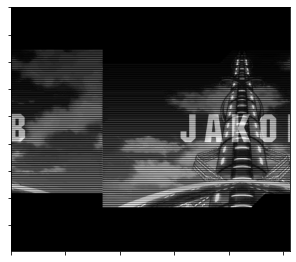

In [140]:
DEBUG = True

# for op_file in [
#                 pathlib.Path('textures/2D_LOAD_ELEVATOR.1E3EE6FB'), 
#                 pathlib.Path('textures/2D_LOAD_ONPARE.1E3EE6FB'), 
#                 pathlib.Path('textures/2D_LOAD_SIGMA.1E3EE6FB'), 
#                 pathlib.Path('textures/2D_LOAD_OP.1E3EE6FB'), 
#                 pathlib.Path('textures/intro.1E3EE6FB'), 
#                 pathlib.Path('textures/title.1E3EE6FB')]:

all_remains = []
failed_files = []
ran_out_of_bytes = []

def printd(st):
    if DEBUG:
        print(st)

if DEBUG:
    l = [pathlib.Path('textures/2D_LOAD_ELEVATOR - Copy.1E3EE6FB')]
    # l = [pathlib.Path('textures/cockpit.1E3EE6FB')]
else:
    l = tqdm(list(pathlib.Path('textures').glob('*.1E3EE6FB')))

for op_file in l:
    try:
        file = open(op_file, 'rb')
    except PermissionError:
        file.close()
        printd('Cannot open due to permission')
        continue
    
    try:
        reader = FileStream(file)

        oop_header = reader.read_string(8)
        file_size = reader.read_int(4)
        unk1 = reader.read_byte_array(4)

        count = reader.read_int(4)
        printd(f'*********There are {count} files in {op_file} **********')

        offsets = []

        for _ in range(count):
            offset = reader.read_int(4)
            offsets.append(offset)
            # print(f"offset = {offset:X}")

        file_size_dupe = reader.read_int(4)

        all_shapes = {off: [] for off in offsets}
        all_n_images = {off: -1 for off in offsets}

        for file_idx, offset in enumerate(offsets):
            reader.seek(offset)

            all_extra_ints = {}
            wpg_header = reader.read_byte_array(16)
            wpg_temp = reader.read_string()

            wpg_magic1 = reader.read_byte_array(20)

            wpg_id = reader.read_string()

            wpg_magic2 = reader.read_byte_array(4)

            wpg_n_images = reader.read_int(4)
            all_n_images[offset] = wpg_n_images
            printd(f'There are {wpg_n_images} wpgs in {offset} currently we are at {reader.tell()}')

            # unk_offset = 3
            wpg_unk1 = reader.read_byte_array(84)
            # print(reader.read_int())
            
            for i in range(wpg_n_images):
                # reader.read_byte_array(unk_offset)

                width = reader.read_int()
                height = reader.read_int()

                all_shapes[offset].append((width, height))
                check = reader.tell()
                wpg_unk2 = reader.read_int_array(14*2, size_bytes=1)
                reader.seek(check)

                wpg_unk2_p2 = reader.read_int_array(14)

                all_extra_ints[i] = wpg_unk2
                # wpg_unk2 = reader.read_byte_array(28)
                print(f'tell={reader.tell()}, offset={offset}, im={i}, w={width}, h={height}')
                print('\t[1b]', [f'{h:03}' for h in wpg_unk2])
                print('\t[2b]', [f'{h:03}' for h in wpg_unk2_p2])
                print('\t[1b_x]', [f'0x{h:02X}' for h in wpg_unk2])
                print('\t[2b_x]', [f'0x{h:02X}' for h in wpg_unk2_p2])

            printd(f'Data starting at {reader.tell()}')
            # reader.seek(1420)

            # if DEBUG:
            #     ncols = min(wpg_n_images, 3)
            #     nrows = max(1, round(wpg_n_images / ncols))
            #     fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
            #     fig.suptitle(f'File {file_idx+1}/{count} at offset {offset}')
            #     print(nrows, ncols)

            # data_start_offset = reader.tell()
            for i in range(wpg_n_images):
                shape = all_shapes[offset][i]
                want = (shape[0]*shape[1])

                # bpp_mode = all_extra_ints[i][6]
                bpp_mode = -1
                for att_bpp in all_extra_ints[i]:
                    if att_bpp == 8 or att_bpp == 16:
                        bpp_mode = att_bpp
                        break
                printd(f'idx={i}, w={shape[0]}, h={shape[1]}, tell={reader.tell()}/{reader.total_bytes()}, want={want}, bpp={bpp_mode}, extra={all_extra_ints[i]}')
                if bpp_mode == 8:
                    s1 = min(all_extra_ints[i][0], shape[0])
                    s2 = min(all_extra_ints[i][8], shape[1])
                    shape = (s1, s2)
                    want += 512
                elif bpp_mode == 16:
                    want += 1024
                else:
                    printd('Invalid bpp')
                im_data = reader.read(want)
                if not im_data:
                    # print(f'Ran out of bytes')
                    ran_out_of_bytes.append(op_file)
                    break
                
                im = Image.frombytes("L", shape, im_data, 'raw', 'L', 0, -1)

                # pal_mode = 'RGB'
                # if pal_mode == 'RGB':
                #     arr = reader.read_int_array(768, size_bytes=1)
                # else:
                #     arr = reader.read_int_array(1024, size_bytes=1)
                # im.putpalette(arr, pal_mode)
                im = im.convert('RGB')
                im.save(f'figures2/{op_file.stem}.png')
                # print(np.array(im).shape)
                # np.save('test.npy', np.array(im))
            
                if DEBUG:
                    # if type(ax) != np.ndarray:
                    #     curr = ax
                    # elif len(ax.shape) == 1:
                    #     curr = ax[i]
                    # else:
                    #     r = i // ncols
                    #     c = i % ncols
                    #     curr = ax[r][c]
                    fig, curr = plt.subplots(figsize=(5, 5))
                    curr.set_xticklabels([])
                    curr.set_yticklabels([])
                    curr.imshow(im)
                # curr.set_title(f'i={i+1}/{wpg_n_images}')
                # plt.tight_layout()
                # plt.savefig(f'figures/{i}.png')

        # print(f'Tell finished at {reader.tell()}/{reader.total_bytes()} so {reader.total_bytes()-reader.tell()} bytes remain')
        # print(all_shapes)
        # print(all_n_images)
        all_remains.append(reader.total_bytes()-reader.tell())

        file.close()
    except Exception as ex:
        failed_files.append(op_file)
        if DEBUG:
            ex.with_traceback()
        continue

print('Remains', np.unique(all_remains))
print('Failed', len(failed_files))
print('Ran out of bytes', len(ran_out_of_bytes))

# Remains [     0     76    140    172    204 165684]
# Failed 142
# Ran out of bytes 33

In [332]:

# shape = (256, 128)
# # bytes_per_pixel = 1
# # next_read = shape[0]*shape[1]*bytes_per_pixel
# # print(f'tell={reader.tell()}, total={reader.total_bytes()}, want to read {next_read}')
# # rem_data = reader.read(next_read)
# rem_data = reader.read_remaining_bytes()
# # for mode in Image.MODES:
# #     try:
# #         im = Image.frombytes(mode, (128, 128), rem_data)
# #         plt.figure(figsize=(10, 10))
# #         plt.suptitle(mode)
# #         plt.imshow(im)
# #         plt.tight_layout()
# #     except Exception as ex:
# #         print(f'{mode} runs with exception', ex)

# # im = Image.frombytes("P", (512, 256), rem_data, "raw", "P", 0, -1)
# im = Image.frombytes("RGBA", shape, rem_data)

# # rem_data = reader.read(next_read)
# # im2 = Image.frombytes("L", shape, rem_data)

# arr = np.array(im)
# print(arr.min(), arr.max(), arr.mean(), arr.dtype, arr.shape)
# # im = Image.frombytes("F", (256, 256), rem_data, "bit", 24, 0, 0, 0, -1)
# plt.figure(figsize=(10, 10))
# plt.imshow(im, cmap='gray')
# plt.tight_layout()

# # plt.figure(figsize=(10, 10))
# # plt.imshow(im2, cmap='gray')

# print(f'count={count}, n_images={wpg_n_images}, tell=0x{reader.tell():X}, total={reader.total_bytes()}, rem={len(rem_data)}')

In [ ]:
class OOPImageFile(ImageFile.ImageFile):
    format = "OOP"

    def _open(self):
        self.fp: io.FileIO
        reader = FileStream(self.fp)
        oop_header = reader.read(128)
        file_size = reader.read_int(4)

        unk1 = reader.read_byte_array(4)
        # print(unk1)

        count = reader.read_int(4)

        offsets = []

        for _ in range(count):
            offset = reader.read_int(4)
            offsets.append(offset)
            print(f"offset = {offset:X}")

        file_size_dupe = reader.read_int(4)

        reader.seek(offsets[0])

        wpg_header = reader.read_byte_array(16)
        wpg_temp = reader.read_string()

        wpg_magic1 = reader.read_byte_array(20)

        wpg_id = reader.read_string()

        wpg_magic2 = reader.read_byte_array(4)

        wpg_n_images = reader.read_int(4)

        wpg_magicff = reader.read_byte_array(65)
        wpg_unk1 = reader.read_int()

        self._size = (512, 256)


Image.register_open(OOPImageFile.format, OOPImageFile, lambda prefix: prefix[:3] == b"OOP")

Image.register_extensions(
    OOPImageFile.format,
    [".oop", ".1E3EE6FB"]
)

In [23]:
Image.MODES

['1', 'CMYK', 'F', 'HSV', 'I', 'L', 'LAB', 'P', 'RGB', 'RGBA', 'RGBX', 'YCbCr']

In [206]:
# start = 0
# pbar = tqdm(range(1000000))
# for i in pbar:
#     reader.seek(start)
#     reader.read(i)
#     rem = reader.read_remaining_bytes()
#     if len(rem) <= 0:
#         break
#     pbar.set_postfix_str(len(rem))
#     im_data = io.BytesIO()
#     try:
#         im = Image.open(im_data, formats=None)
#         print(im.width, im.height)
#     except Image.UnidentifiedImageError:
#         continue
